<a href="https://www.kaggle.com/penghai/cs247-anime-recommendation-engine?scriptVersionId=89940882" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CS247 Anime Recommendation Engine - Baseline and Anime Embedding

This notebook serves as project for CS247 Advanced Data Mining.

Group member:
* Yiming Shi 905525611
* Penghai Wei 105726519
* Yongqian Li 004997466
* Yanxun Li 005712570

In this notebook we will build a recomender system using dataset **Anime Recommendation Database 2020**.

The notebook contains the following serveral sections:
* Input Processing
* Baseline Construction
* Side Feature Embedding
* Utilizing Side Feature

# Input Processing

In this section, we mainly extract the basic input from "animelist.csv". We cleaned the data, remove duplicate data, normalized the score value, and present an overview of the rating matrix.

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Loading input
INPUT_DIR = '/kaggle/input/anime-recommendation-database-2020'
!ls {INPUT_DIR}

 anime.csv		   animelist.csv   rating_complete.csv
 anime_with_synopsis.csv  'html folder'    watching_status.csv


In [16]:
# Loading Rating Data
rating_df = pd.read_csv(INPUT_DIR + '/animelist.csv',
                        nrows=5000000,
                        low_memory=False, 
                        usecols=["user_id", "anime_id", "rating", "watching_status"]
                        )

# User should rate atleast 400 animies
n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()
rating_df = rating_df[rating_df['watching_status'] < 6].copy()
len(rating_df)


2369743

In [17]:
# Scaling BTW (0 , 1.0)
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
rating_df['rating'] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

AvgRating = np.mean(rating_df['rating'])
print('Avg', AvgRating)

Avg 0.562491924229694


In [18]:
# Removing Duplicated Rows
duplicates = rating_df.duplicated()

if duplicates.sum() > 0:
    print('> {} duplicates'.format(duplicates.sum()))
    rating_df = rating_df[~duplicates]

print('> {} duplicates'.format(rating_df.duplicated().sum()))

> 0 duplicates


In [19]:
# Quick review of our rating matrix
g = rating_df.groupby('user_id')['rating'].count()
top_users = g.dropna().sort_values(ascending=False)[:20]
top_r = rating_df.join(top_users, rsuffix='_r', how='inner', on='user_id')

g = rating_df.groupby('anime_id')['rating'].count()
top_animes = g.dropna().sort_values(ascending=False)[:20]
top_r = top_r.join(top_animes, rsuffix='_r', how='inner', on='anime_id')

pd.crosstab(top_r.user_id, top_r.anime_id, top_r.rating, aggfunc=np.sum)

anime_id,20,1535,1575,4224,5081,5114,6547,8074,9253,9919,10620,11757,15809,16498,19815,20507,22319,30276,31240,31964
user_id,,,,,,,,,,,,,,,,,,,,
781,0.7,1.0,0.6,0.7,0.5,NaN,0.9,0.8,1.0,0.7,0.9,0.6,0.7,0.9,0.7,0.7,0.7,1.0,0.8,0.8
890,0.7,0.9,0.7,0.4,0.2,0.9,0.7,0.6,NaN,NaN,0.6,0.1,NaN,0.7,NaN,NaN,NaN,0.7,NaN,NaN
1397,NaN,0.9,0.9,0.9,0.9,1.0,0.8,NaN,0.8,0.7,0.7,0.8,0.6,0.8,0.7,0.8,0.7,0.7,0.9,0.8
1469,0.7,0.7,0.9,0.6,0.8,0.8,0.7,0.9,0.3,0.7,0.6,0.9,0.9,0.9,0.9,0.5,0.5,0.9,0.8,0.6
4773,0.7,0.7,0.9,0.8,0.9,0.9,0.8,0.7,1.0,NaN,0.9,0.7,0.8,0.8,0.4,0.8,0.7,0.8,0.9,0.5
5045,0.7,0.8,NaN,0.9,NaN,NaN,NaN,0.5,0.9,NaN,0.7,0.5,0.7,0.8,0.7,NaN,NaN,0.8,0.8,0.8
5648,0.7,1.0,1.0,1.0,0.9,1.0,1.0,0.8,1.0,0.8,0.8,1.0,0.9,1.0,1.0,1.0,0.7,0.8,1.0,0.8
6852,1.0,1.0,NaN,1.0,NaN,NaN,1.0,0.9,1.0,NaN,1.0,1.0,NaN,1.0,0.9,0.8,NaN,0.6,NaN,NaN
7179,0.6,0.7,0.9,0.7,0.8,1.0,0.7,0.7,0.7,0.6,0.8,0.4,0.8,0.7,0.7,0.7,0.6,0.7,0.7,0.5


In [20]:
# Generate Training and testing data.

# Encoding categorical data
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
n_users = len(user2user_encoded)

anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
n_animes = len(anime2anime_encoded)

print("Num of users: {}, Num of animes: {}".format(n_users, n_animes))
print("Min rating: {}, Max rating: {}".format(min(rating_df['rating']), max(rating_df['rating'])))

Num of users: 4203, Num of animes: 15500
Min rating: 0.0, Max rating: 1.0


In [21]:
# Shuffle
rating_df = rating_df.sample(frac=1, random_state=73)

X = rating_df[['user', 'anime']].values
y = rating_df["rating"]

In [22]:
# Split
test_set_size = 1000 #1k for test set
train_indices = rating_df.shape[0] - test_set_size 
test_indicies = rating_df.shape[0] - test_set_size 

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[test_indicies:],
    y[:train_indices],
    y[test_indicies:],
)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))

> Train set ratings: 2368743
> Test set ratings: 1000


# Baseline Construction

In this baseline, we use the naive collaborative filtering method. The general idea behind this is that we are predicting what users will like based on their similarity to other users. We simply use the rating matrix generated in the last section, and perform matrix factorization on it.


In [23]:
# set the training and testing array
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [24]:
# Setup TPU
import tensorflow as tf

TPU_INIT = False

if TPU_INIT:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    !nvidia-smi
    
print(tf.__version__)

/bin/bash: nvidia-smi: command not found
2.6.2


## Baseline Model

In [25]:
import keras
from keras import layers 
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

def BaselineNet():
    embedding_size = 128
    
    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding',
                       input_dim = n_users, 
                       output_dim = embedding_size)(user)
    
    anime = Input(name = 'anime', shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding',
                       input_dim = n_animes, 
                       output_dim = embedding_size)(anime)
    
    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
    x = Flatten()(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')
    
    return model

if TPU_INIT:    
    with tpu_strategy.scope():
        model = BaselineNet()
else:
    model = BaselineNet()

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 128)       537984      user[0][0]                       
__________________________________________________________________________________________________
anime_embedding (Embedding)     (None, 1, 128)       1984000     anime[0][0]                      
____________________________________________________________________________________________

In [26]:
# Callbacks
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = './weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

early_stopping = EarlyStopping(patience = 3, monitor='val_loss', 
                               mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    #early_stopping,   
]

In [27]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
237/237 [==============================] - 11s 43ms/step - loss: 0.8033 - mae: 0.3397 - mse: 0.1637 - val_loss: 0.7326 - val_mae: 0.3219 - val_mse: 0.1393
Epoch 2/20
237/237 [==============================] - 10s 41ms/step - loss: 0.8006 - mae: 0.3384 - mse: 0.1626 - val_loss: 0.7925 - val_mae: 0.3386 - val_mse: 0.1615
Epoch 3/20
237/237 [==============================] - 10s 41ms/step - loss: 0.7959 - mae: 0.3363 - mse: 0.1608 - val_loss: 0.8077 - val_mae: 0.3424 - val_mse: 0.1663
Epoch 4/20
237/237 [==============================] - 10s 40ms/step - loss: 0.7892 - mae: 0.3332 - mse: 0.1581 - val_loss: 0.8068 - val_mae: 0.3419 - val_mse: 0.1660
Epoch 5/20
237/237 [==============================] - 10s 42ms/step - loss: 0.7804 - mae: 0.3291 - mse: 0.1546 - val_loss: 0.8025 - val_mae: 0.3402 - val_mse: 0.1644
Epoch 6/20
237/237 [==============================] - 10s 40ms/step - loss: 0.7688 - mae: 0.3235 - mse: 0.1498 - val_loss: 0.7956 - val_mae: 0.3372 - val_mse: 0.1619
Epoc

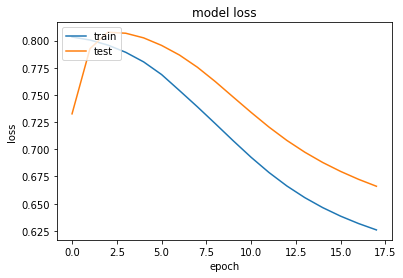

In [28]:
#Training results
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Side Feature Embedding

Noticed in our dataset, we also have the anime name, synopsis, and genres information. We want to use this side features, since it contains many info that might be useful. We utilize a pretrained bert model for embedding and use tensorboard for embeding visualization.

## Loading Synopsis Data

In [ ]:
# loading Synopsis Data
anime_synopsis_df = pd.read_csv(INPUT_DIR + '/anime_with_synopsis.csv', 
                        low_memory=False, 
                        )
len(anime_synopsis_df)

We tried bert model with different size from HuggingFace. We stored the embeding result in pickle files so that we don't need to rerun this section again.

Here is the links for the model we tried.
* https://huggingface.co/bert-base-uncased
* https://huggingface.co/distilbert-base-uncased
* https://huggingface.co/prajjwal1/bert-tiny

In [ ]:
# loading pretrained bert
from transformers import AutoTokenizer, AutoModel #for embeddings

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny",)
bert_model = AutoModel.from_pretrained("prajjwal1/bert-tiny",output_hidden_states=True)

In [ ]:
import torch
#create embeddings
def get_embeddings(text,token_length):
    tokens=tokenizer(text,max_length=token_length,padding='max_length',truncation=True)
    output=bert_model(torch.tensor(tokens.input_ids).unsqueeze(0),
                 attention_mask=torch.tensor(tokens.attention_mask).unsqueeze(0)).hidden_states[-1]
    return torch.mean(output,axis=1).detach().numpy()

get_embeddings("Action", 1).shape

In [ ]:
# processing genres
# get all unique genres
from tqdm import tqdm
import pickle

genres_embeddings_map = {}

for _, j in tqdm(anime_synopsis_df.iterrows(), total=anime_synopsis_df.shape[0]):
    gList = j["Genres"].split(', ')
    for g in gList:
        if g not in genres_embeddings_map:
            genre_embedding = get_embeddings(g, 1)
            genres_embeddings_map[g] = genre_embedding

f = open("genre_embedding_map_small.pkl","wb")
pickle.dump(genres_embeddings_map,f)
f.close()

In [ ]:
# translate animies into embedding
from tqdm import tqdm
import pickle

# check for Nan
anime_synopsis_df.dropna(subset=['sypnopsis'], inplace=True)

anime_embedding_map = {}

for _, j in tqdm(anime_synopsis_df.iterrows(), total=anime_synopsis_df.shape[0]):
    name_embedding = get_embeddings(j["Name"], 10)    
    sypnopsis_embedding = get_embeddings(j["sypnopsis"], 50)
    anime_embedding_map[j["MAL_ID"]] = np.append(name_embedding[0], sypnopsis_embedding[0])
    
f = open("anime_embedding_map_small.pkl","wb")
pickle.dump(anime_embedding_map,f)
f.close()

In [ ]:
# loading embeding pkl file
import pickle

anime_embedding_map = {}
# with open('../input/embedding-small/anime_embedding_map.pkl', 'rb') as f: # distilbert-base-uncased
with open('../input/new-embedding/anime_embedding_map_small_new.pkl', 'rb') as f: # prajjwal1/bert-tiny
    anime_embedding_map = pickle.load(f)

print(len(anime_embedding_map))

### Subsample input Due to Resource limit

In [ ]:
print(len(anime_embedding_map))
# process input
rating_df = rating_df[rating_df["anime_id"].isin(anime_embedding_map.keys())]
print(len(rating_df))

In [ ]:
sampled_rating_df = rating_df.sample(frac=0.4, replace=False, random_state=1)

n_ratings = sampled_rating_df['user_id'].value_counts()
sampled_rating_df = sampled_rating_df[sampled_rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()
len(sampled_rating_df)

In [ ]:
sampled_rating_df.to_csv("data.csv", encoding='utf-8', index=False)

## Visualization Using Tensorboard

To visualize the embedding result. I converted the data into tsv file which tensorboard accepts.

We could use https://projector.tensorflow.org/ to visualize the embedding result.

In [ ]:
# visualize 
import csv

g_list=list(genres_embeddings_map.keys())
g_embedding_list=list(genres_embeddings_map.values())
embeddings = np.concatenate(g_embedding_list, axis=0)

np.savetxt('g_embedding.tsv', embeddings, delimiter='\t')

with open('g.tsv', 'w') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\n')
    tsv_output.writerow(g_list)

## Loading Embedding

Since we stored the embedding in pickle files, we don't need to recalculate the embeddings. We could load from the pickle files.

In [29]:
# loading embeding pkl file
import pickle

anime_embedding_map = {}
# with open('../input/embedding-small/anime_embedding_map.pkl', 'rb') as f: # distilbert-base-uncased
with open('../input/embedding-small/anime_embedding_map_small.pkl', 'rb') as f: # prajjwal1/bert-tiny
    anime_embedding_map = pickle.load(f)

print(len(anime_embedding_map))

16214


# Use Side Feature Embedding

## Using Anime Embedding
First we modify the training and testing data from using ids to using anime embedding

In [30]:
# change anime to anime embedding
user_train = np.array(X_train[:, 0])
anime_train_list = X_train[:, 1].tolist()

anime_train = []
for i in anime_train_list:
    if i in anime_embedding_map:
        anime_train.append(anime_embedding_map[i])
    else:
        anime_train.append(np.random.rand(256))
anime_train = np.array(anime_train)

In [31]:
# change anime to anime embedding
user_test = np.expand_dims(np.array(X_test[:, 0]), axis = 1)
anime_test_list = X_test[:, 1].tolist()

anime_test = []
for i in anime_test_list:
    if i in anime_embedding_map:
        anime_test.append(anime_embedding_map[i])
    else:
        anime_test.append(np.random.rand(256))
anime_test = np.array(anime_test)

### Model

In [32]:
import keras
from keras import layers 
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

# Embedding layers
def Anime_Embedding_Net():
    embedding_size = 128
    
    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding',
                       input_dim = n_users, 
                       output_dim = embedding_size)(user)
    user_embedding = Flatten()(user_embedding)
    
    anime = Input(name = 'anime', shape = [256])
    anime_embedding = Dense(512, activation='relu')(anime)
    anime_embedding = Dense(256, activation='relu')(anime_embedding)
    anime_embedding = Dense(128, activation='softmax')(anime_embedding)

    
    x = Dot(name = 'dot_product', normalize = True, axes = 1)([user_embedding, anime_embedding])
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')
    
    return model

print(TPU_INIT)
if TPU_INIT:    
    with tpu_strategy.scope():
        model = Anime_Embedding_Net()
else:
    model = Anime_Embedding_Net()

model.summary()

False
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anime (InputLayer)              [(None, 256)]        0                                            
__________________________________________________________________________________________________
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          131584      anime[0][0]                      
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 128)       537984      user[0][0]                       
______________________________________________________________________________________

In [33]:
# Callbacks
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

start_lr = 0.0001
min_lr = 0.00001
max_lr = 0.001
batch_size = 4096

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = './weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

early_stopping = EarlyStopping(patience = 3, monitor='val_loss', 
                               mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    #early_stopping,   
]

In [34]:
# Model training
history = model.fit(
    x=[user_train, anime_train],
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=((user_test, anime_test), y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
579/579 [==============================] - 51s 86ms/step - loss: 0.6083 - mae: 0.2270 - mse: 0.0827 - val_loss: 0.5874 - val_mae: 0.2119 - val_mse: 0.0746
Epoch 2/20
579/579 [==============================] - 46s 80ms/step - loss: 0.5887 - mae: 0.2101 - mse: 0.0748 - val_loss: 0.5818 - val_mae: 0.1991 - val_mse: 0.0724
Epoch 3/20
579/579 [==============================] - 45s 79ms/step - loss: 0.5860 - mae: 0.2039 - mse: 0.0738 - val_loss: 0.5780 - val_mae: 0.1946 - val_mse: 0.0709
Epoch 4/20
579/579 [==============================] - 46s 80ms/step - loss: 0.5796 - mae: 0.1973 - mse: 0.0711 - val_loss: 0.5699 - val_mae: 0.1911 - val_mse: 0.0680
Epoch 5/20
579/579 [==============================] - 46s 79ms/step - loss: 0.5720 - mae: 0.1900 - mse: 0.0678 - val_loss: 0.5645 - val_mae: 0.1794 - val_mse: 0.0654
Epoch 6/20
579/579 [==============================] - 47s 81ms/step - loss: 0.5695 - mae: 0.1876 - mse: 0.0668 - val_loss: 0.5694 - val_mae: 0.1862 - val_mse: 0.0678
Epoc

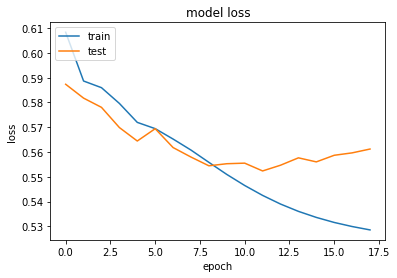

In [35]:
#Training results
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Though the model is a little bit overfit. But we could find that the actual loss is smaller than the baseline.